# TouchPass 2019 to 2021 Comparison

There have been many changes in public transit ridership since 2019. There was a global pandemic beginning in March 2020 that tanked public transit ridership. Even now in the later summer of 2021, those effects can still be seen. 

The following analysis will look at mobile faring data for the PART Express system in 2019, which we'll call our baseline ridership trends and in 2021, which will be post-pandemic trends. We will try to understand how passenger's behaviors have changed over the last few years.

We'll begin by importing the necessary libraries and getting the data.

In [153]:
# Import libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns = 999

In [105]:
# define parameters
url = 'https://touchpass.com/ams/rest/v1/reporting/faretx/'
api_key = os.environ.get('TOUCHPASS_API_KEY')

start2019 = '2019-08-01T10:00:00Z'
end2019 = '2019-11-01T04:00:00Z'

start2021 = '2021-05-01T10:00:00Z'
end2021 = '2021-08-01T04:00:00Z'

headers = {
    'accept': 'application/json',
    'Api-Token': api_key,
    'Agency-ID': '9K7A4H9JHRVQ'
}

In [134]:
%%time

# call api and save to variable
response2019 = requests.get(url + start2019 + '/' + end2019, headers=headers).json()
response2021 = requests.get(url + start2021 + '/' + end2021, headers=headers).json()

# write response to dataframe
df2019 = pd.DataFrame(response2019)
df2021 = pd.DataFrame(response2021)


print('Finished reading {:,} transactions from 2019, \nand {:,} transactions from 2021...'.format(len(df2019), len(df2021)))

Finished reading 40,451 transactions from 2019, 
and 28,592 transactions from 2021...
Wall time: 9.13 s


In [135]:
df2019.info()
df2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40451 entries, 0 to 40450
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   txId            40451 non-null  int64  
 1   ts              40451 non-null  object 
 2   type            40451 non-null  object 
 3   mediaUsed       40451 non-null  object 
 4   mediaType       40450 non-null  object 
 5   cardNumber      40450 non-null  object 
 6   fareType        40451 non-null  object 
 7   accountId       40450 non-null  float64
 8   stopName        35442 non-null  object 
 9   stopId          35442 non-null  object 
 10  routeName       40450 non-null  object 
 11  latitude        40451 non-null  float64
 12  longitude       40451 non-null  float64
 13  reader          40451 non-null  object 
 14  vehicle         40450 non-null  object 
 15  readerPosition  40451 non-null  int64  
 16  fare            40451 non-null  int64  
 17  passUsed        24450 non-null 

In [136]:
def data_processing(df):
    # remove rows with no cardNumber
    df.dropna(subset=['cardNumber'], inplace=True)
    
    # get and remove employee transactions
    emp_cards = df.loc[df['fareType'] == 'Employee', 'cardNumber'].unique()
    df = df[~df['cardNumber'].isin(emp_cards)]
    
    # Convert ts to a datetime object
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Create new Date field and convert ts from UTC to local time
    df['date'] = df['ts'].dt.tz_convert('US/Eastern')
    
    # Create date only and time only fields
    df['date_only'] = df['date'].dt.date
    df['time_only'] = [dt.datetime.time(d) for d in df['date']]
    
    # create transfer attribute in data
    df['transfer'] = np.where(df.groupby('cardNumber')['date'].diff() <= pd.Timedelta(minutes=95), 'Y', 'N')

In [137]:
# apply function to both dataframes
data_processing(df2019)
data_processing(df2021)

Now that we have cleaned up the data a bit and added a few new attributes, let's dig into the data sets. First, let's see how many unique passengers are in the two data sets.

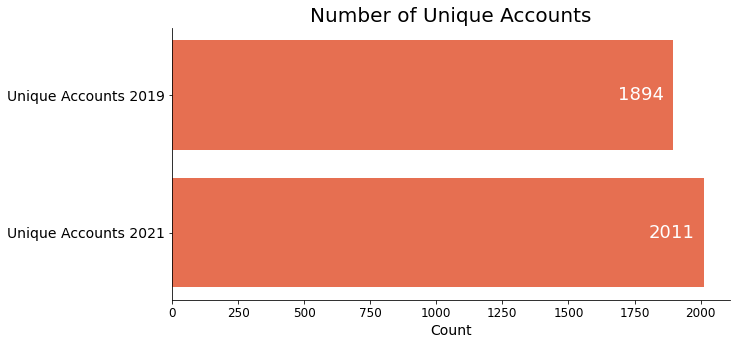

In [178]:
num_uniq_cards_2019 = df2019['cardNumber'].nunique()
num_uniq_cards_2021 = df2021['cardNumber'].nunique()

labels = ('Unique Accounts 2019', 'Unique Accounts 2021')
count = [num_uniq_cards_2019, num_uniq_cards_2021]
y_pos = np.arange(len(labels))

fig, ax  = plt.subplots(figsize=(10,5))

hbars = ax.barh(y_pos, count, align='center', color='#E66F51')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.invert_yaxis()
ax.bar_label(hbars, fontsize=18, padding=-55, color='white')

plt.title('Number of Unique Accounts', fontsize=20)
plt.xticks(fontsize=12)
plt.xlabel('Count', fontsize=14)

sns.despine()
plt.show()

We can see that there are more active accounts in 2021 than there were in 2019, but not by many.

In [157]:
cards_diff = num_uniq_cards_2021 - num_uniq_cards_2019
per_diff_cards = (num_uniq_cards_2021 - num_uniq_cards_2019) / num_uniq_cards_2019

print('There are {} more cards in 2021 than in 2019. This is a {:.2%} difference'.format(cards_diff, per_diff_cards))

There are 117 more cards in 2021 than in 2019. This is a 6.18% difference


Let's find out how many cards exist in both data sets. This means that the passenger utilized TouchPass in 2019 and continues to use TouchPass in 2021.

In [158]:
# get list of unique cardnumbers for both data sets
uniq_cards_2019 = df2019['cardNumber'].unique()
uniq_cards_2021 = df2021['cardNumber'].unique()

In [166]:
# get overlapping cardnumbers
longterm_pass = [card for card in uniq_cards_2021 if card in uniq_cards_2019]

In [167]:
print('There are {} passengers who are present in both data sets'.format(len(longterm_pass)))

There are 84 passengers who are present in both data sets


In [184]:
per_overlap = len(longterm_pass) / num_uniq_cards_2021

print('Those 84 passengers represent approximately {:.2%} of the 2021 data set'.format(per_overlap))

Those 84 passengers represent approximately 4.18% of the 2021 data set


This tells us that most of our current passengers are new to PART or new to TouchPass.

### Other questions to ask of the data
- How many transfers a day are there?
- How many routes are passengers using?
- How many stops are passengers using?
- How many days are passengers riding?

In [185]:
df2019['routeName'].value_counts()

4                8752
2                8353
1                5670
DEFAULT          3422
6                3077
3                2974
23               1440
17               1040
22                994
20                986
North Shuttle     702
21                694
South Shuttle     678
27                429
28                417
10                357
9                 183
19                147
5                 135
Name: routeName, dtype: int64

In [186]:
df2021['routeName'].value_counts()

2                9104
3                4297
1                4086
4                2665
DEFAULT          1321
17               1150
22                956
21                822
24                808
6                 709
23                616
20                546
20/21             445
22/23             361
10                310
9                 192
South Shuttle     108
North Shuttle      82
ID: 4014720         4
ID: 4014724         4
5                   3
ID: 4014708         1
Name: routeName, dtype: int64